# Goal:

Develop a model that outputs the expected number of user ratings on the website Vivino.com when input the price and quality rating of the wine.

### No correlation found between wine price and quality and how many Vivino users rate the wine.
Searched over many pricing and number of ratings ranges, sliced data on wines made in the US, those made in Napa Valley, and without any regional condition.  R^2 never exceeded 0.15

In [55]:
import matplotlib.pyplot as plt
import pandas            as pds
import seaborn           as sns
import numpy             as np
import sklearn

#Regression Modeling
from sklearn.linear_model    import Lasso as LSO, ElasticNet as ELN, Ridge as RDG
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor as RFR, GradientBoostingRegressor as GBR
from sklearn.ensemble        import AdaBoostRegressor as ABR
#Testing
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics         import classification_report as cr, r2_score as r2
from sklearn.metrics         import accuracy_score as ac, mean_squared_error as mse
#Outlier Detection
from sklearn.neighbors       import LocalOutlierFactor as LOF
from sklearn.ensemble        import IsolationForest as ISF
from sklearn.covariance      import EllipticEnvelope as ELE
from sklearn.decomposition   import PCA


df = pds.read_csv('vivino_white_wine.csv', sep=",", header=0, encoding='ISO-8859-15')
df['rating']     = df['rating'].astype(float)
df['pricing']    = df['pricing'].str.replace('$', '')
df['pricing']    = df['pricing'].astype(float)
df['popularity'] = df['popularity'].astype(float)

Number of data entries for prices < $100 and popularity > 50 votes:  949


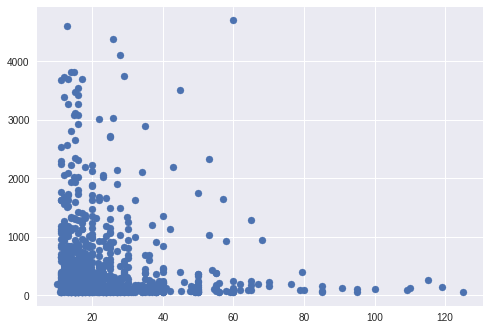

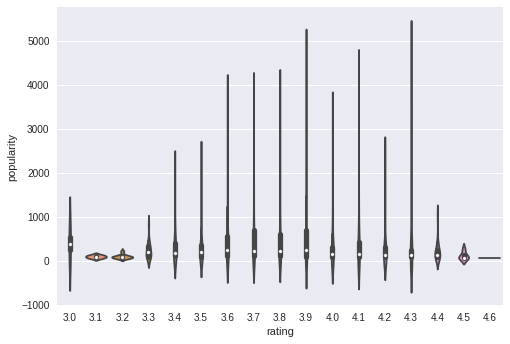

In [193]:
# print(df[(df['country'] == 'United States')].region.unique())

max_pricing = 125
min_popularity = 50
country = 'United States'
max_popularity = 5000

df_mod = df[(df['pricing'] < max_pricing) & (abs(df['popularity']) > min_popularity) & \
         (abs(df['popularity']) < max_popularity) & (df['country'] == country)]#(df['region'] == 'Napa Valley')]
df_mod.index = range(len(df_mod)); df_mod = df_mod.drop('Unnamed: 0', 1)
print('Number of data entries in sliced database: ', len(df_mod))
plt.scatter(df_mod['pricing'], df_mod['popularity'])
plt.show()

sns.violinplot(df_mod['rating'], df_mod['popularity'])
plt.show()

In [194]:
df_mod.copy()
ft = df_mod.columns[-3:]
print(ft)
df_results = df_mod[ft[:2]]
df_targets = df_mod[ft[-1]]

Index(['rating', 'pricing', 'popularity'], dtype='object')


In [195]:
LOF_list = LOF().fit_predict(df_mod[ft])
ISF_fit  = ISF().fit(df_mod[ft])
ISF_list = ISF_fit.predict(df_mod[ft])

LOF_outliers = []; ISF_outliers = []
for i in range(len(LOF_list)):
    if LOF_list[i] == -1:
        LOF_outliers.append(i)
    if ISF_list[i] == -1:
        ISF_outliers.append(i)

print('number of points cut by LOF outlier search: ', len(LOF_outliers))
print('number of points cut by ISF outlier search: ', len(ISF_outliers))

df_LOF       = df_mod.drop(df_mod.index[LOF_outliers])
df_LOF.index = range(len(df_LOF))
df_ISF       = df_mod.drop(df_mod.index[ISF_outliers])
df_ISF.index = range(len(df_ISF))

df_LOF_PCA               = pds.DataFrame(PCA().fit_transform(df_LOF[ft[:2]]))
df_ISF_PCA               = pds.DataFrame(PCA().fit_transform(df_ISF[ft[:2]]))
df_PCA                   = pds.DataFrame(PCA().fit_transform(df_mod[ft[:2]]))
df_LOF_PCA['popularity'] = df_LOF['popularity']
df_ISF_PCA['popularity'] = df_ISF['popularity']
df_PCA['popularity']     = df_mod['popularity']

print('\n')
print('Number of empty cells in df_LOF_PCA: ', df_LOF_PCA.isnull().sum().sum())
print('Number of empty cells in df_ISF_PCA: ', df_ISF_PCA.isnull().sum().sum())
print('Number of empty cells in df_PCA    : ', df_PCA.isnull().sum().sum())
print('\n')
print('Total number of rows in df_LOF_PCA: ', len(df_LOF_PCA))
print('Total number of rows in df_ISF_PCA: ', len(df_ISF_PCA))
print('Total number of rows in df_PCA    : ', len(df_PCA))

number of points cut by LOF outlier search:  95
number of points cut by ISF outlier search:  95


Number of empty cells in df_LOF_PCA:  0
Number of empty cells in df_ISF_PCA:  0
Number of empty cells in df_PCA    :  0


Total number of rows in df_LOF_PCA:  854
Total number of rows in df_ISF_PCA:  854
Total number of rows in df_PCA    :  949


In [196]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_mod, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []; ABR_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ABR(); ABR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [197]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; ABR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    ABR_predicted.extend(ABR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

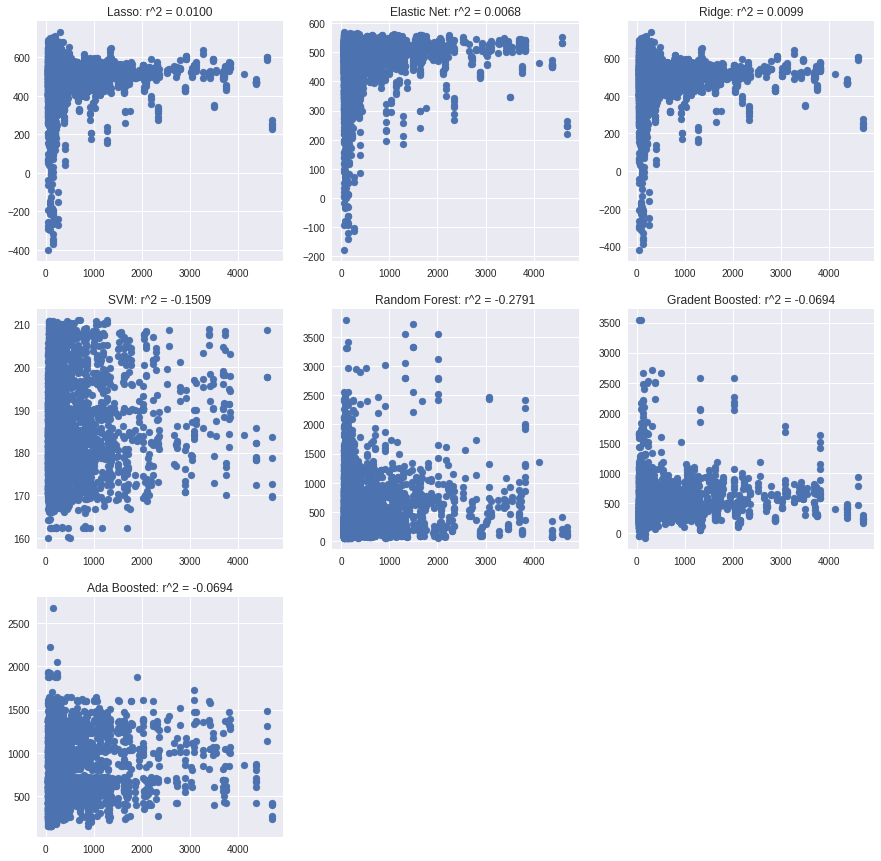

In [198]:
plt.figure(1, figsize=(15, 15))
plt.subplot(3,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: r^2 = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(3,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: r^2 = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(3,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: r^2 = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(3,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: r^2 = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(3,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: r^2 = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(3,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: r^2 = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.subplot(3,3,7); plt.scatter(Expected, ABR_predicted); 
plt.title('Ada Boosted: r^2 = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [199]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_LOF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [200]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

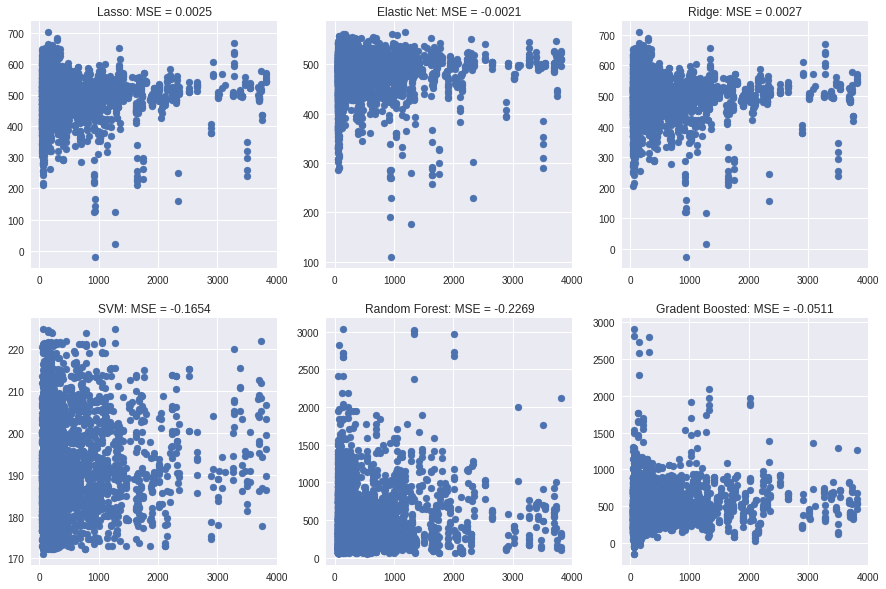

In [201]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [202]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_LOF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [203]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

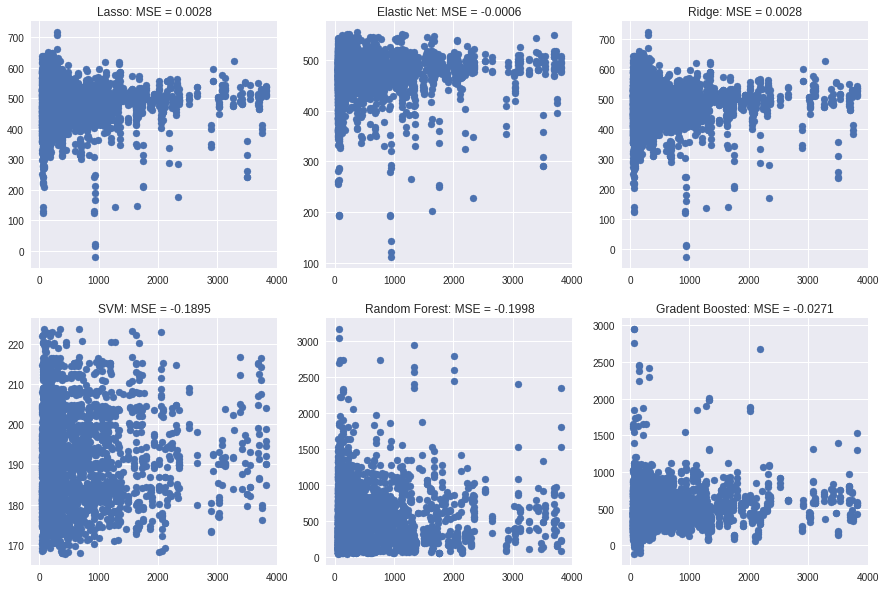

In [204]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [205]:
training_list = []; testing_list = []
for i in range(20):
    train, test = tts(df_ISF, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [206]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

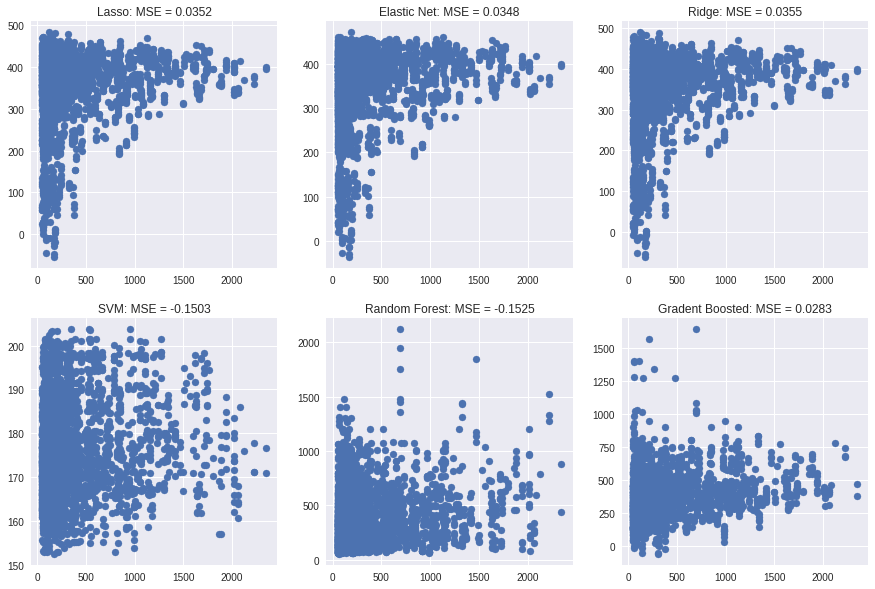

In [207]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

In [208]:
training_list = []; testing_list = []
ft = df_PCA.columns
for i in range(20):
    train, test = tts(df_PCA, test_size=0.2)
    training_list.append(train)
    testing_list.append(test)
LSO_models = []; ELN_models = []; RDG_models = []
GBR_models = []; RFR_models = []; SVR_models = []
for training_set in training_list:
    model = LSO(); LSO_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = ELN(); ELN_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))
    model = RDG(); RDG_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = GBR(); GBR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]])) 
    model = RFR(); RFR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))   
    model = SVR(kernel='rbf'); SVR_models.append(model.fit(training_set[ft[:2]], training_set[ft[-1]]))

In [209]:
LSO_predicted = []; ELN_predicted = []; RDG_predicted = []; GBR_predicted = [] 
RFR_predicted = []; SVR_predicted = []; Expected = []
for i in range(len(testing_list)):
    LSO_predicted.extend(LSO_models[i].predict(testing_list[i][ft[:2]]))
    ELN_predicted.extend(ELN_models[i].predict(testing_list[i][ft[:2]]))
    RDG_predicted.extend(RDG_models[i].predict(testing_list[i][ft[:2]]))
    GBR_predicted.extend(GBR_models[i].predict(testing_list[i][ft[:2]]))
    RFR_predicted.extend(RFR_models[i].predict(testing_list[i][ft[:2]]))
    SVR_predicted.extend(SVR_models[i].predict(testing_list[i][ft[:2]]))
    Expected.extend(testing_list[i][ft[-1]])

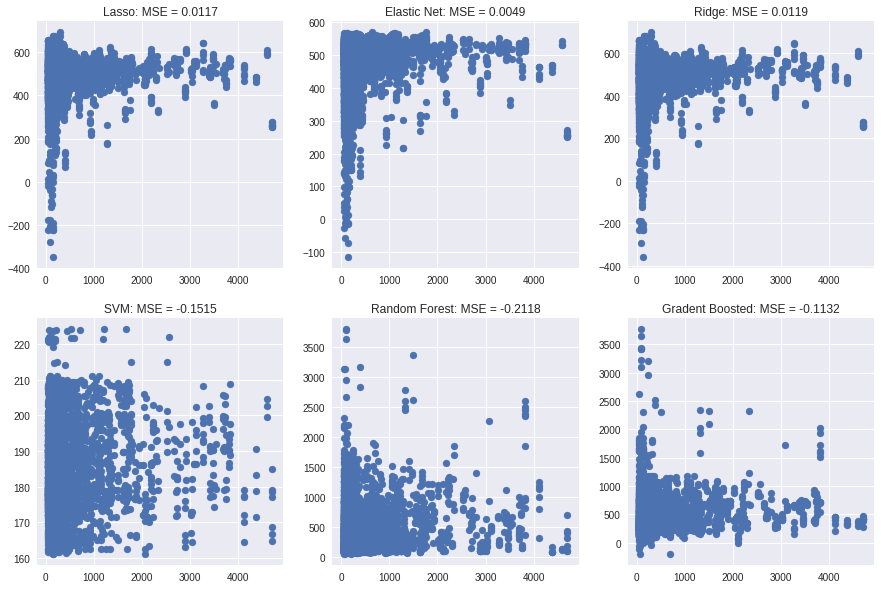

In [210]:
plt.figure(1, figsize=(15, 10))
plt.subplot(2,3,1); plt.scatter(Expected, LSO_predicted) 
plt.title('Lasso: MSE = {0:.4f}'.format(r2(Expected, LSO_predicted)))
plt.subplot(2,3,2); plt.scatter(Expected, ELN_predicted) 
plt.title('Elastic Net: MSE = {0:.4f}'.format(r2(Expected, ELN_predicted)))
plt.subplot(2,3,3); plt.scatter(Expected, RDG_predicted); 
plt.title('Ridge: MSE = {0:.4f}'.format(r2(Expected, RDG_predicted)))
plt.subplot(2,3,4); plt.scatter(Expected, SVR_predicted); 
plt.title('SVM: MSE = {0:.4f}'.format(r2(Expected, SVR_predicted)))
plt.subplot(2,3,5); plt.scatter(Expected, RFR_predicted); 
plt.title('Random Forest: MSE = {0:.4f}'.format(r2(Expected, RFR_predicted)))
plt.subplot(2,3,6); plt.scatter(Expected, GBR_predicted); 
plt.title('Gradent Boosted: MSE = {0:.4f}'.format(r2(Expected, GBR_predicted)))
plt.show()

# Appendix: Scraping Vivino for White Wines > $10

## Download White Wine Data From Vivino.com

Before running this download the file chromedriver, you will need to enter the path to this file below:

driver = webdriver.Chrome(executable_path='path', chrome_options=options)

if you are using Windows input the path to chromedriver under the if statement:

if os.name == 'nt'

otherwise enter it under the else statement

Chrome 59 or greater is required for the headless option to work.  Script should still run, just not headless.

Libraries:
* conda install -c conda-forge selenium
* https://sites.google.com/a/chromium.org/chromedriver/downloads

Note:  Red wine script included below, but is not completed.  I'm tired and want to go to bed.  Future Chris can deal with it.

In [53]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException
import time
import os
import csv
import pandas as pd

options = webdriver.ChromeOptions(); options.add_argument('headless')
if os.name == 'nt':
    driver = webdriver.Chrome(executable_path='D:\orson\Downloads\chromedriver_win32\chromedriver', chrome_options=options)    
else:
    driver = webdriver.Chrome(executable_path='/home/chris/Downloads/chromedriver', chrome_options=options)

country_list = []; rating_list = []; popular_list = []; price_list = []
wine_list    = []; winery_list = []
site_list    = ['https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1NFDLTaywNTRWS660LS1WKwCKF9smJ6qVJduWFJWmqpWXRMfaGgEAb34PXA==',\
                'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1NFbLTaywNTRTS660LS1WKwCKF9smJ6qVJduWFJWmqpWXRMfaGgEAcE0PYg==',\
                'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1NFPLTaywNTJQS660LS1WKwCKF9smJ6qVJduWFJWmqpWXRMfaGgEAcCUPYA==',\
                'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1MlDLTaywNTJVS660LS1WKwCKF9smJ6qVJduWFJWmqpWXRMfaGgEAcAMPYA==',\
                'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1MlXLTaywNTVQS660LS1WKwCKF9smJ6qVJduWFJWmqpWXRMfaGgEAcIYPYw==',\
                'https://www.vivino.com/explore?e=eJzLLbI1VMvNzLM1NVDLTawAUgZqyZW2pcVqBUCJYtvkRLWyZNuSotJUtfKS6FhbIwB7dQ-R']

driver.get(site_list[0])
df_name_list = ['wine','winery','region','country','rating','pricing','popularity']
df = pd.DataFrame(columns = df_name_list); number = 0

for site in range(len(site_list)):
    print("Starting Scrape of {0} of {1} Websites".format(site+1, len(site_list)))
    driver.get(site_list[site])

    lastHeight = driver.execute_script("return document.body.scrollHeight")
    total_time = 0; total_page_loads = 0
    while True:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        newHeight = driver.execute_script("return document.body.scrollHeight")
        if newHeight == lastHeight and total_time > 15:
            print('  No new data on this site'); break
        time.sleep(0.25); total_time += 0.25
        if lastHeight < newHeight:
            if total_page_loads % 5 == 0:
                print("  Pages Loaded:   ", total_page_loads)
            total_page_loads += 1; total_time = 0; lastHeight = newHeight

    time.sleep(5.0)
    for i in range(1000):
        try:
            header          = '//section[@class="wine-explorer__results"]/div[{}]'.format(i+1)
            wine_path       = '/div[1]/div[1]/a[1]'   + '/span[1]'
            winery_path     = '/div[1]/div[1]/a[1]'   + '/span[2]'
            region_path     = '/div[1]/div[1]/div[1]' + '/a[3]'
            country_path    = '/div[1]/div[1]/div[1]' + '/a[2]'
            popularity_path = '/div[1]/div[1]/div[2]' + '/div[1]/div[2]/div[2]/div[2]/span[1]/span[1]'
            rating_path     = '/div[1]/div[1]/div[2]' + '/div[1]/div[2]/div[1]'
            pricing_path    = '/div[1]/div[1]/div[2]' + '/div[2]/div[2]/div[1]/span[1]'            

            wine       = driver.find_element_by_xpath(header + wine_path).text
            winery     = driver.find_element_by_xpath(header + winery_path).text
            popularity = driver.find_element_by_xpath(header + popularity_path).text
            rating     = driver.find_element_by_xpath(header + rating_path).text
            country    = driver.find_element_by_xpath(header + country_path).text
            region     = driver.find_element_by_xpath(header + region_path).text
            pricing    = driver.find_element_by_xpath(header + pricing_path).text
            entry      = [wine, winery, region, country, rating, pricing, popularity]
            df         = df.append(pd.DataFrame([entry],columns=df_name_list), ignore_index=True)
        except NoSuchElementException:
            pass
    
    print('Number of entries in the database: ', len(df))
    number += int(driver.find_element_by_xpath('//div[@class="query-summary__primary"]/span[3]').text)
    print("Total number of wines loaded: ", number, '\n\n')

df.to_csv('vivino_white_wine.csv')
print("\n\nThat's all Folks!")


Starting Scrape of 1 of 6 Websites
  Pages Loaded:    0
  Pages Loaded:    5
  Pages Loaded:    10
  Pages Loaded:    15
  Pages Loaded:    20
  No new data on this site
Number of entries in the database:  484
Total number of wines loaded:  485 


Starting Scrape of 2 of 6 Websites
  Pages Loaded:    0
  Pages Loaded:    5
  Pages Loaded:    10
  Pages Loaded:    15
  Pages Loaded:    20
  Pages Loaded:    25
  No new data on this site
Number of entries in the database:  1041
Total number of wines loaded:  1043 


Starting Scrape of 3 of 6 Websites
  Pages Loaded:    0
  Pages Loaded:    5
  Pages Loaded:    10
  Pages Loaded:    15
  Pages Loaded:    20
  Pages Loaded:    25
  No new data on this site
Number of entries in the database:  1698
Total number of wines loaded:  1700 


Starting Scrape of 4 of 6 Websites
  Pages Loaded:    0
  Pages Loaded:    5
  Pages Loaded:    10
  Pages Loaded:    15
  No new data on this site
Number of entries in the database:  2166
Total number of win

In [ ]:
# move = webdriver.ActionChains(driver)
# move = ActionChains(driver)
# slider = driver.find_element_by_xpath('//span[@class="ui-slider-handle ui-corner-all ui-state-default"]')

# elements = [driver.find_element_by_xpath('//span[@class="ui-slider-handle ui-corner-all ui-state-default"]'),
#             driver.find_element_by_xpath('//div[@class="query-summary__primary"]'),
#             driver.find_element_by_xpath('//span[@class="wine-explorer__filters__item__header__title"]')]
# for item in elements:
#     time.sleep(5)
#     print("Test")
#     move.move_to_element(item).perform()
# move.click_and_hold(slider).move_by_offset(20, 0).release()

# time.sleep(5)
# move.click_and_hold(slider

# time.sleep(5)
# move.click_and_hold(slider).move_by_offset(20, 0).release()




    
    
    
#     header_elements     = driver.find_element_by_class_name('wine-card__content')
#     price_elements      = driver.find_elements_by_xpath('//div[@class="wine-card__statistics"]/div[2]/div[2]/div[1]/span[1]')
#     country_elements    = driver.find_elements_by_xpath('//div[@class="location"]/a[2]')
#     popularity_elements = driver.find_elements_by_xpath('//div[@class="statistics-item__content__description"]/div[2]/span[1]/span[1]')
#     rating_elements     = driver.find_elements_by_xpath('//div[@class="wine-card__statistics"]/div[1]/div[2]/div[1]')
#     wine_elements       = driver.find_elements_by_xpath('//a[@class="wine-card__header"]/span[2]')
#     winery_elements     = driver.find_elements_by_xpath('//a[@class="wine-card__header"]/span[1]')
    
#     for card in header_elements:
#         print('\n\n', card)
#         print('Winery     : ', card.find_elements_by_xpath('//div[@class="wine-card__content"]/a[1]/span[1]').text)
#         print('Wine       : ', card.find_elements_by_xpath('//div[@class="wine-card__content"]/a[1]/span[2]').text)
#         print('Country    : ', card.find_elements_by_xpath('//div[1]/a[2]').text)
#         print('Region     : ', card.find_elements_by_xpath('//div[1]/a[3]').text)
#         print('Rating     : ', card.find_elements_by_xpath('//div[2]/div[1]').text)
#         print('Popularity : ', card.find_elements_by_xpath('//div[2]/div[1]/div[2]/div[2]/div[2]/span[1]/span[1]').text)
#         print('Pricy      : ', card.find_elements_by_xpath('//div[2]/div[2]/div[2]/div[1]/span[1]').text)
                
#     print('Testing    : ', driver.find_element_by_xpath('//div[@class="wine-card__content"][1]'))
#     print('Testing    : ', driver.find_element_by_xpath('//div[@class="wine-card__content"][2]'))
#     print(header_elements[1])
#     print(header_elements[0])


#     prices       = [x.text for x in price_elements]
#     countries    = [x.text for x in country_elements]
#     popularities = [x.text for x in popularity_elements]
#     ratings      = [x.text for x in rating_elements]
#     wineries     = [x.text for x in winery_elements]
#     wines        = [x.text for x in wine_elements]
#     number       = driver.find_element_by_xpath('//div[@class="query-summary__primary"]/span[3]').text

#     print("Sanity check should find ", number, " wines in each list")
#     print(len(countries)); 
#     while len(countries) < int(number):
#         countries.append('')
#     country_list = country_list + countries
#     print(len(ratings));    
#     while len(ratings) < int(number):
#         ratings.append('')
#     rating_list  = rating_list  + ratings
#     print(len(prices));     
#     while len(prices) < int(number):
#         prices.append('')
#     price_list   = price_list   + prices
#     print(len(popularities)); 
#     while len(popularities) < int(number):
#         popularities.append('')
#     popular_list = popular_list + popularities
#     print(len(wines))
#     while len(wines) < int(number):
#         wines.append('')
#     wine_list = wine_list + wines
#     print(len(wineries))
#     while len(wineries) < int(number):
#         wineries.append('')
#     winery_list = winery_list + wineries


# outputter = pd.DataFrame({'wine':wine_list, 'winery':winery_list, 'country':country_list, 'rating':rating_list, \
#                           'price':price_list, 'popularity':popular_list})
# outputter.to_csv('vivino_white_wine.csv')